# [11] Keras Testing Safe vs Malignant
This is the code for creating our final Tensorflow Keras CNN model. We made multiple different versions of the model and those can be loaded down below or can be run to get a similar model. Based on some earlier tests, we found that setting weights and preventing the model from choosing just one category was difficult with more than 3 categories and so considering our time constraints we decided to just classify Safe vs Malignant. This meant grouping normal and benign together as our 0 class and malignant as our 1 class. This also has the nice result of meaning our data is split nearly exactly 50/50 with {0: 1278, 1: 1298} counts of each class. For our inputs we are using the full concatenated images rather than eigenvectors because by using a Conv2D layer the model is able to actually pick out features from the image. We use code from a few different sources here that are all cited in the comments of the functions. I followed the tutorial sent to us (linked below) initially but then branched off to customize the keras code some more.

https://victorzhou.com/blog/keras-cnn-tutorial/: For initial basis to set up the model

Additionally some functions were used from online sources to improve the quality of the code:

https://deeplizard.com/learn/video/14syUbL16k4: For a plot function to display ImageDataGenerator results

https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5: For real-time plotting of training metrics while the models train


In [1]:
## Import libraries

%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)
import seaborn as sns

import pickle
import random
import math as m
import time
import pandas as pd
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
from skimage.transform import resize
import mnist
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import BinaryCrossentropy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.layers
from collections import Counter
from IPython.display import clear_output

import keras_tuner as kt

In [2]:
## loading in important variables
scale = (162, 135)

# Keys
with open('OFFICIAL_keys.pkl', 'rb') as f:
    keys = pickle.load(f)
train_set = keys[:int(0.8*len(keys))]
test_set = keys[int(0.8*len(keys)):int(0.9*len(keys))+1]
validation_set = keys[int(0.9*len(keys))+1:]

# Classifications
with open('classifications.pkl', 'rb') as f:
    classifications = pickle.load(f)
classes = []
for i in range(2575):
    if classifications[2*i] != classifications[2*i+1]:
        print("Classification not equal")
    classes.append(classifications[2*i])
classes = np.array(classes)

# Abnormalities
with open('abnormalities.pkl', 'rb') as f:
    abnormalities = pickle.load(f)
abnorms = []
for i in range(2575):
    if abnormalities[2*i] != abnormalities[2*i+1]:
        print("abnormalities not equal")
    abnorms.append(abnormalities[2*i])
abnorms = np.array(abnorms)

with open('orientations.pkl', 'rb') as f:
    orientations = pickle.load(f)
orientations = np.array(orientations)    

In [3]:
## Function to display the confusion matrix of a model's predictions

# Note citation this function was written by me (Max) but line 29:
# sns.heatmap(conmat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
# is from the function previously used for the conf_mat function that was used from
# https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights

def conf_mat(pred, ground, title="Confusion Matrix", conf_in_percent=False, print_percentages=False, scale_weights=False):
    cats = ground.max()+1
    conmat = np.zeros((cats,cats))
    for i in range(pred.shape[0]):
        y = pred[i]
        x = ground[i]
        if scale_weights: scale = class_weights[x]*class_weights[y]
        else: scale = 1
        conmat[x, y] += 1*scale
    if print_percentages:
        pred_per = np.empty((cats, 2))
        ground_per = np.empty((cats, 2))
        for i in range(cats):
            pred_per[i] = [i,(np.count_nonzero(pred==i)/pred.shape[0])*100]
            ground_per[i] = [i,(np.count_nonzero(ground==i)/pred.shape[0])*100]
        print()
        print(f"Predicted Percentages: \n{pred_per}\n")
        print(f"Ground Percentages: \n{ground_per}\n")
    if conf_in_percent:
        if scale_weights: size = np.sum(conmat)
        else: size = pred.shape[0]
        conmat = np.round_((conmat / size)*100, 1)
    plt.figure(figsize=(3,3))
    sns.set(font_scale=1) 
    sns.heatmap(conmat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Value")
    plt.ylabel("Actual Value")
    plt.title(title)
    return conmat

In [4]:
## Raw accuracy test function
def accuracy(pred, ground):
    c = 0
    for i in range(pred.shape[0]):
        if pred[i] == ground[i]:
            c+=1
    return c/pred.shape[0]

In [5]:
## Takes flattened images (wxh, n), eigenvectors for the set, and k = new dimensionality
## Returns an array similar to flattened images array but with k instead of n dimensions
def reduce_dimensionality(imgs, vecs, k):
    reduced_dim = np.matmul(vecs[:k], imgs)
    return reduced_dim

## Converts the reduced dimension scan back to original image dimension
def reduced_to_img(reduced, vecs):
    approx = np.matmul(vecs[:reduced.shape[0]].T, reduced)
    return approx

## Combined the above two functions for convenience in creating downscaled images
def reduce_img_dim(imgs, vecs, k):
    return reduced_to_img(reduce_dimensionality(imgs, vecs, k), vecs)

In [6]:
## Set Labels
label_classes = ["Safe", "Malignant"]
labels = []
for i in range(classes.shape[0]):
    if classes[i] == "D2 Normal":
        labels.append(0)
    elif classes[i] == "Benign":
        labels.append(0)
    else:
        labels.append(1)
labels = np.array(labels)

In [7]:
## Set X and y
with open('concat_imgs.npy', 'rb') as f:
    concat_imgs = pickle.load(f)

concat_imgs = np.reshape(concat_imgs, (concat_imgs.shape[0], scale[0]*2, scale[1]))
concat_imgs = np.expand_dims(concat_imgs, 3)

X_train = concat_imgs[train_set]
X_test = concat_imgs[test_set]
X_validation = concat_imgs[validation_set]
y_train = labels[train_set]
y_test = labels[test_set]
y_validation = labels[validation_set]

In [8]:
## Helper function to plot images for the ImageDataGenerator demo below
## From https://deeplizard.com/learn/video/14syUbL16k4
def plotImages(images_arr, num_imgs=10):
    fig, axes = plt.subplots(1, num_imgs, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

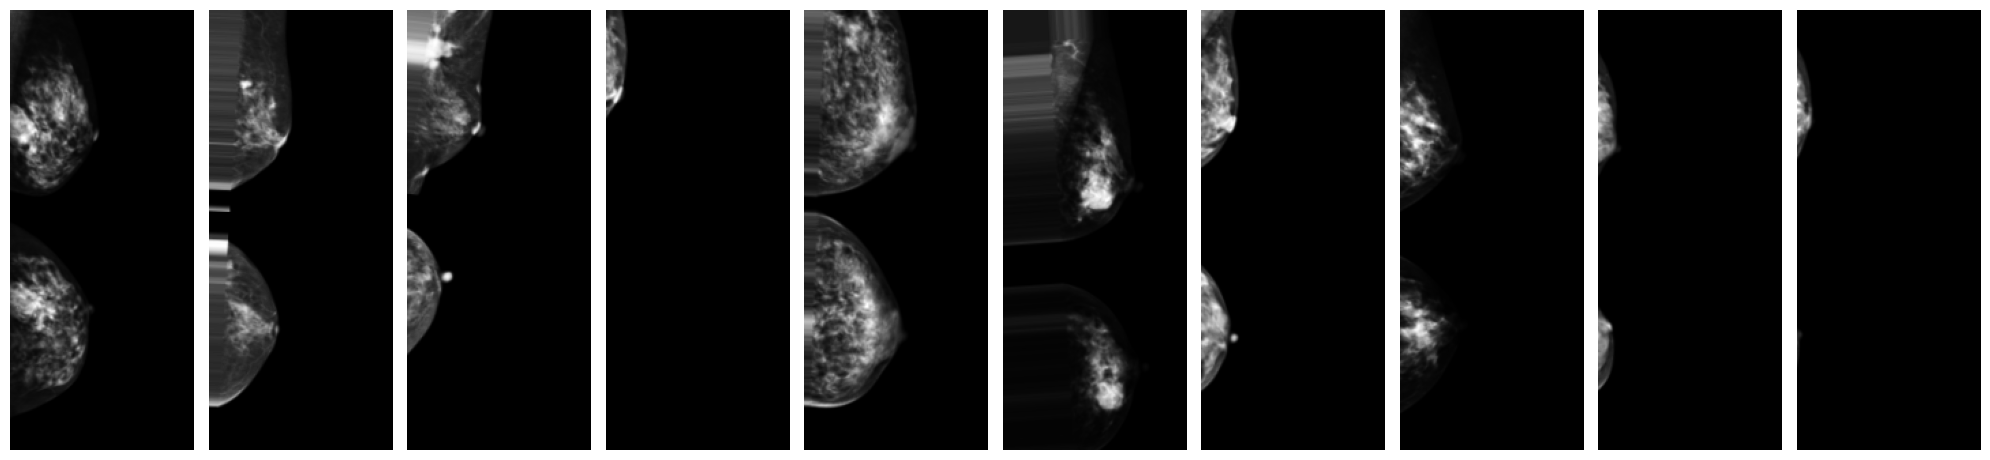

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
                         height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,)

to_expand = X_train
to_expand = np.reshape(to_expand, (to_expand.shape[0], scale[0]*2, scale[1]))
to_expand = np.expand_dims(to_expand, 3)
gen.fit(to_expand)
plotImages(gen.flow(to_expand)[0][0:10])

In [10]:
counter = Counter(y_train)                          
max_val = float(max(counter.values()))       
default_class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}   
print(default_class_weights)

{1: 1.0, 0: 1.0019436345966959}


In [11]:
## From https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5
## Function to provide graphs while training model
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [29]:
## Print Results of Model
def print_results(model=model):
    print(f"Epochs so far: {epochs_on_model}\n")

    raw_predictions = model.predict(X_train)
    predictions = np.argmax(raw_predictions, axis=1)
    print(f"Train Accuracy = {accuracy(predictions, y_train)}")

    raw_predictions = model.predict(X_test)
    predictions = np.argmax(raw_predictions, axis=1)
    print(f"Test Accuracy = {accuracy(predictions, y_test)}")

    raw_predictions = model.predict(X_validation)
    predictions = np.argmax(raw_predictions, axis=1)
    print(f"Validation Accuracy = {accuracy(predictions, y_validation)}")

    # print(f"Convolution Matrix:\n{conf_mat(predictions, y_validation, True, True)}")
    unscaled_conv = conf_mat(predictions, y_validation, "Validation Confusion Matrix (% picked)", True, True)

# Models
We trained a few different models with differing layouts to see what performed the best, those models are down below, labeled and in order. I don't know if you want to rerun the training on the models yourselves or if you just want the weights so I'm providing the models, compilers for each, and the weights as well as codeblocks to train them as we did.

Note: Code has sections with comments about how to reload the models, this was included before I realized I wouldn't be including the models with the code upload and so just ignore these and follow the instructions to run the training for the models

In [14]:
def model_builder(hp):
    model = keras.Sequential()
    hp_units1 = hp.Int('filters1', min_value=20, max_value=100, step=10)
    hp_units2 = hp.Int('kernel1', min_value=3, max_value=6, step=1)
    model.add(keras.layers.Conv2D(filters=hp_units1, kernel_size=hp_units2, input_shape=(scale[0]*2, scale[1], 1)))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    hp_units3 = hp.Int('filters2', min_value=10, max_value=30, step=5)
    hp_units4 = hp.Int('kernel2', min_value=2, max_value=3, step=1)
    model.add(keras.layers.Conv2D(filters=hp_units3, kernel_size=hp_units4))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.2))
    hp_units5 = hp.Int('neurons1', min_value=128, max_value=2048, step=64)
    model.add(keras.layers.Dense(units=hp_units5, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    hp_units6 = hp.Int('neurons2', min_value=128, max_value=2048, step=64)
    model.add(keras.layers.Dense(units=hp_units6, activation='relu'))
    model.add(keras.layers.Dense(units=2, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'],)
    return model

In [15]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=200,
                     factor=3,
                     directory='my_dir',
                     project_name='testing_hp_tuning')

INFO:tensorflow:Reloading Oracle from existing project my_dir\testing_hp_tuning\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\testing_hp_tuning\tuner0.json


In [16]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [17]:
tuner.search(gen.flow(X_train, to_categorical(y_train)), epochs=100, validation_data=(X_test, to_categorical(y_test)), callbacks=[stop_early])

Trial 254 Complete [00h 00m 39s]
val_accuracy: 0.5581395626068115

Best val_accuracy So Far: 0.5891472697257996
Total elapsed time: 02h 07m 21s
INFO:tensorflow:Oracle triggered exit


In [17]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('filters1'))
print(best_hps.get('kernel1'))
print(best_hps.get('filters2'))
print(best_hps.get('kernel2'))
print(best_hps.get('neurons1'))
print(best_hps.get('neurons2'))
print(best_hps.get('learning_rate'))

60
5
10
2
1216
832
0.0001


In [18]:
model = tuner.hypermodel.build(best_hps)
epochs_on_model = 0

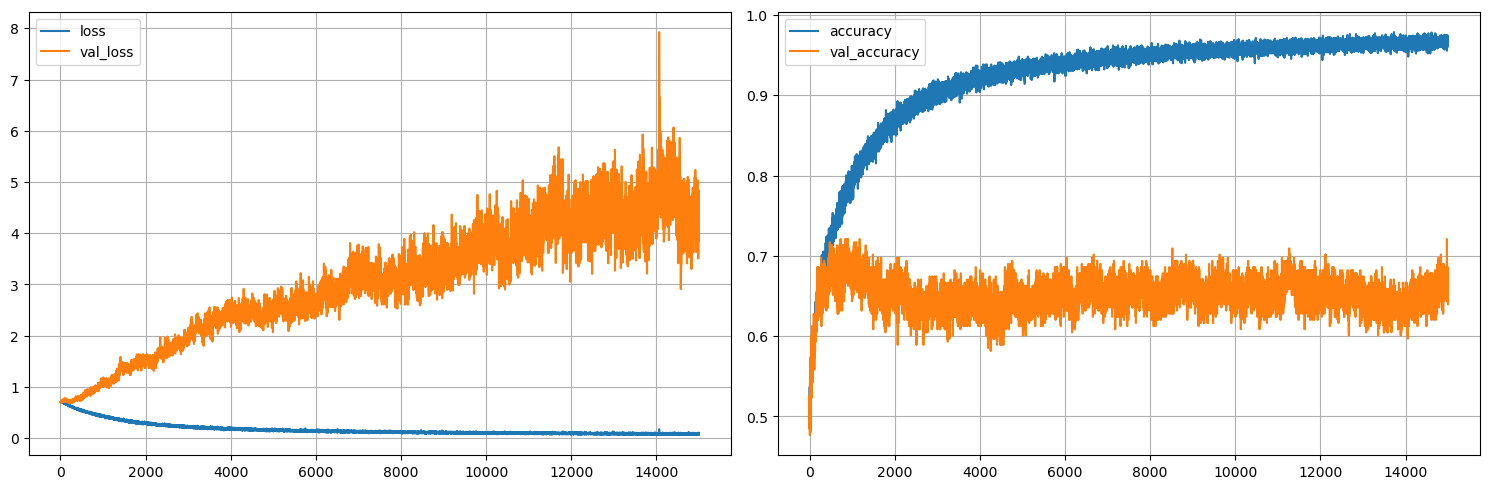

65/65 [==============================] - 5s 80ms/step - loss: 0.0788 - accuracy: 0.9704 - val_loss: 4.8321 - val_accuracy: 0.6628


In [19]:
## Testing Train Model
epochs_this = 15000
epochs_on_model += epochs_this
callbacks_list = [PlotLearning()]
class_weights_biased = {0: 1, 1: 1.05}

history = model.fit(
    gen.flow(X_train, to_categorical(y_train)),
    epochs=epochs_this,
    validation_data=(X_test, to_categorical(y_test)),
    class_weight=class_weights_biased,
    callbacks=callbacks_list,
)

Epochs so far: 15000

65/65 [==============================] - 1s 10ms/step
Train Accuracy = 1.0
9/9 [==============================] - 0s 6ms/step
Test Accuracy = 0.6627906976744186
9/9 [==============================] - 0s 7ms/step
Validation Accuracy = 0.5486381322957199

Predicted Percentages: 
[[ 0.         50.97276265]
 [ 1.         49.02723735]]

Ground Percentages: 
[[ 0.         49.41634241]
 [ 1.         50.58365759]]



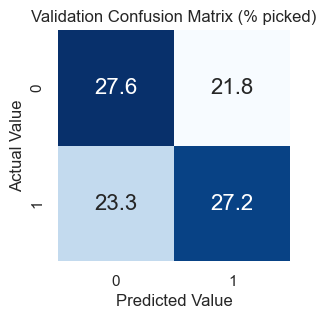

In [20]:
print_results()

In [23]:
model_peak = tuner.hypermodel.build(best_hps)
epochs_on_model = 0

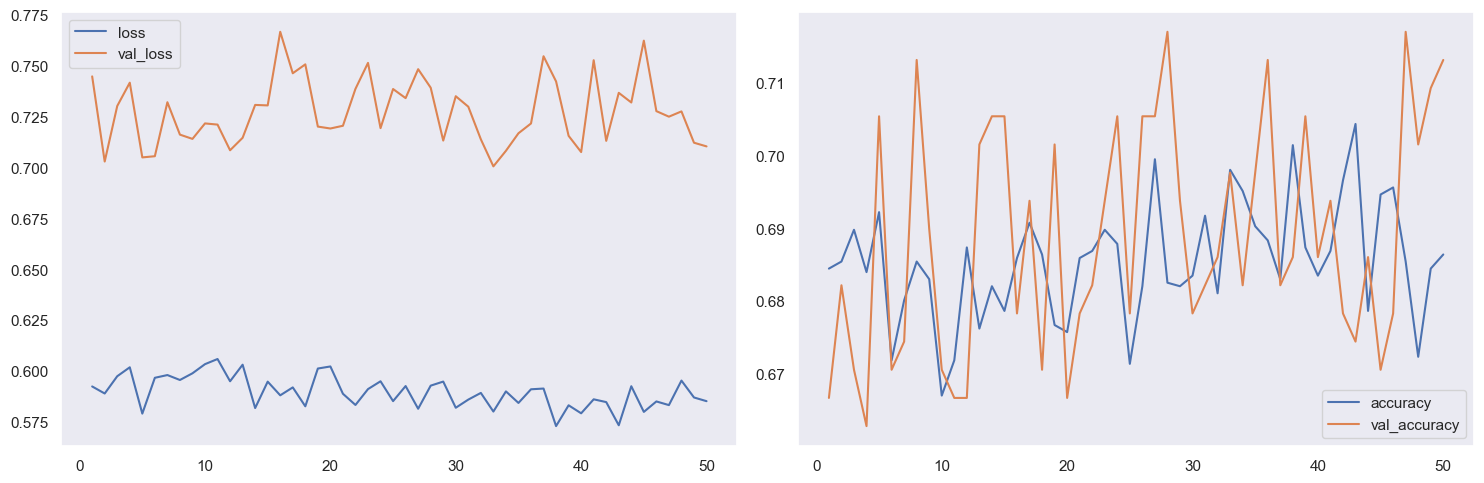

65/65 [==============================] - 5s 77ms/step - loss: 0.5853 - accuracy: 0.6864 - val_loss: 0.7104 - val_accuracy: 0.7132


In [27]:
## Testing Train Model
epochs_this = 50
epochs_on_model += epochs_this
callbacks_list = [PlotLearning()]
class_weights_biased = {0: 1, 1: 1.05}

history_peak = model_peak.fit(
    gen.flow(X_train, to_categorical(y_train)),
    epochs=epochs_this,
    validation_data=(X_test, to_categorical(y_test)),
    class_weight=class_weights_biased,
    callbacks=callbacks_list,
)

Epochs so far: 350

65/65 [==============================] - 0s 6ms/step
Train Accuracy = 0.762621359223301
9/9 [==============================] - 0s 6ms/step
Test Accuracy = 0.7131782945736435
9/9 [==============================] - 0s 6ms/step
Validation Accuracy = 0.6536964980544747

Predicted Percentages: 
[[ 0.         63.81322957]
 [ 1.         36.18677043]]

Ground Percentages: 
[[ 0.         49.41634241]
 [ 1.         50.58365759]]



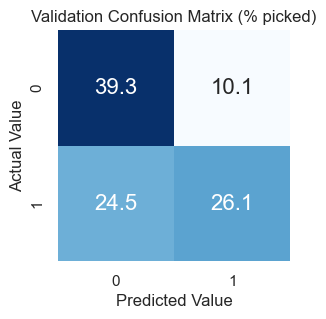

In [30]:
print_results(model_peak)

In [13]:
## Testing Model
model = Sequential([
    Conv2D(filters=100, kernel_size=5, input_shape=(scale[0]*2, scale[1], 1)),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=30, kernel_size=3),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax'),
])

In [14]:
## Testing Compile
opt = keras.optimizers.Adam(learning_rate=0.00005)
epochs_on_model = 0
model.compile(
  opt,
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

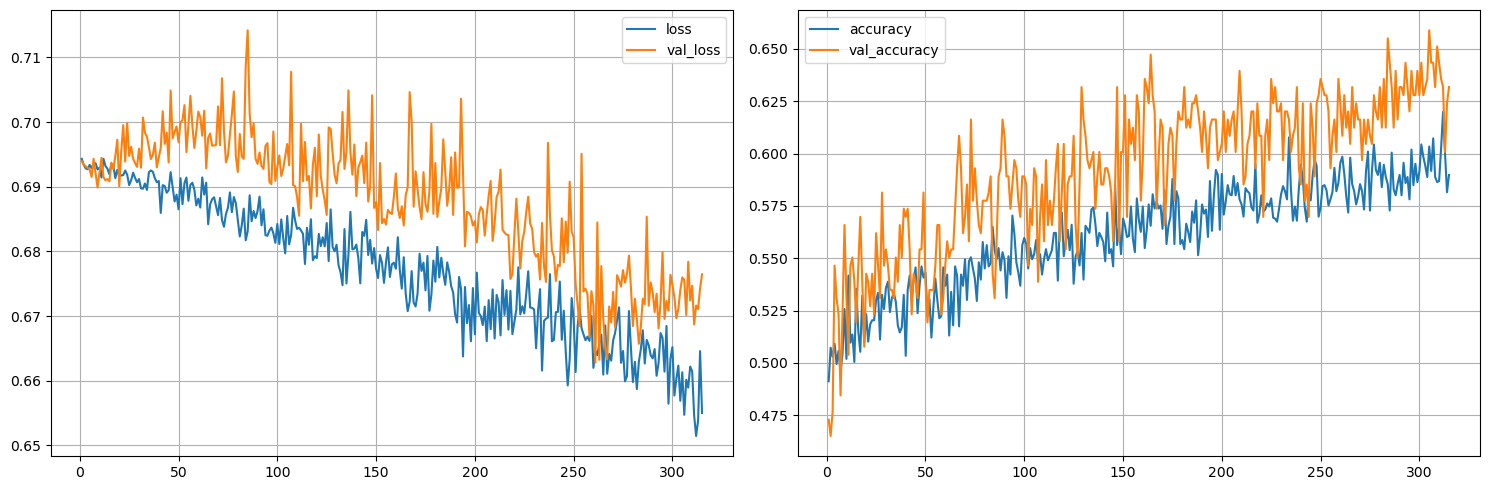

65/65 [==============================] - 5s 73ms/step - loss: 0.6550 - accuracy: 0.5898 - val_loss: 0.6765 - val_accuracy: 0.6318
Epoch 316/5000
65/65 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.5981

KeyboardInterrupt: 

In [15]:
## Testing Train Model
epochs_this = 5000
epochs_on_model += epochs_this
callbacks_list = [PlotLearning()]
class_weights_biased = {0: 1, 1: 1}

model.fit(
    gen.flow(X_train, to_categorical(y_train)),
    epochs=epochs_this,
    validation_data=(X_test, to_categorical(y_test)),
    class_weight=class_weights_biased,
    callbacks=callbacks_list,
)

Epochs so far: 5000

65/65 [==============================] - 2s 36ms/step
Train Accuracy = 0.9737864077669903
9/9 [==============================] - 0s 33ms/step
Test Accuracy = 0.627906976744186
9/9 [==============================] - 0s 36ms/step
Validation Accuracy = 0.5953307392996109

Predicted Percentages: 
[[ 0.        48.6381323]
 [ 1.        51.3618677]]

Ground Percentages: 
[[ 0.         49.41634241]
 [ 1.         50.58365759]]



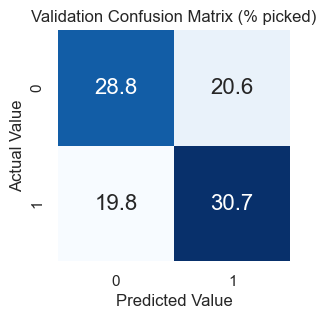

In [17]:
print_results()

In [13]:
## First Good Model ~60-63% accuracy on validation after 510 epochs weighs about 60/40 0/1
# model.save_weights('model1.h5')
model = Sequential([
    Conv2D(filters=10, kernel_size=3, input_shape=(scale[0]*2, scale[1], 1)),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax'),
])
## Uncomment and run the last two lines if you want to load in the model weights
## if you load the model weights you DO NOT need to compile, you can just run more training or print_results()
# model.load_weights('model1.h5')
# epochs_on_model = 510

In [14]:
## Compile Model 1
epochs_on_model = 0
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
## Train Model 1
epochs_this = 510
epochs_on_model += epochs_this
callbacks_list = [PlotLearning()]

model.fit(
    gen.flow(X_train, to_categorical(y_train)),
    epochs=epochs_this,
    validation_data=(X_test, to_categorical(y_test)),
    class_weight=default_class_weights,
    callbacks=callbacks_list,
)

Epochs so far: 510

65/65 [==============================] - 0s 5ms/step
Train Accuracy = 0.6718446601941748
9/9 [==============================] - 0s 3ms/step
Test Accuracy = 0.6124031007751938
9/9 [==============================] - 0s 3ms/step
Validation Accuracy = 0.603112840466926

Predicted Percentages: 
[[ 0.         59.53307393]
 [ 1.         40.46692607]]

Ground Percentages: 
[[ 0.         49.41634241]
 [ 1.         50.58365759]]



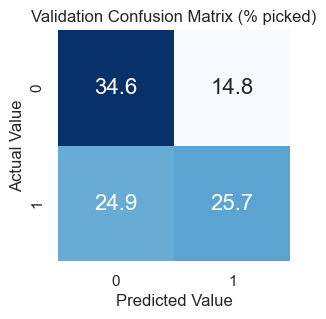

In [26]:
print_results()

In [13]:
## Second Model ~57% accuracy on validation after 200 epochs weighs about 70/30 0/1
# model.save_weights('model2.h5')
model = Sequential([
    Conv2D(filters=20, kernel_size=3, input_shape=(scale[0]*2, scale[1], 1)),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax'),
])
## Uncomment and run the last two lines if you want to load in the model weights
## if you load the model weights you DO NOT need to compile, you can just run the test block
# model.load_weights('model2.h5')
# epochs_on_model = 200

In [ ]:
## Compile Model 2
epochs_on_model = 0
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
## Train Model 2
epochs_this = 200
epochs_on_model += epochs_this
callbacks_list = [PlotLearning()]

model.fit(
    gen.flow(X_train, to_categorical(y_train)),
    epochs=epochs_this,
    validation_data=(X_test, to_categorical(y_test)),
    class_weight=default_class_weights,
    callbacks=callbacks_list,
)

Epochs so far: 200

65/65 [==============================] - 2s 4ms/step
Train Accuracy = 0.5800970873786407
9/9 [==============================] - 0s 4ms/step
Test Accuracy = 0.5658914728682171
9/9 [==============================] - 0s 4ms/step
Validation Accuracy = 0.5680933852140078

Predicted Percentages: 
[[ 0.         70.81712062]
 [ 1.         29.18287938]]

Ground Percentages: 
[[ 0.         49.41634241]
 [ 1.         50.58365759]]



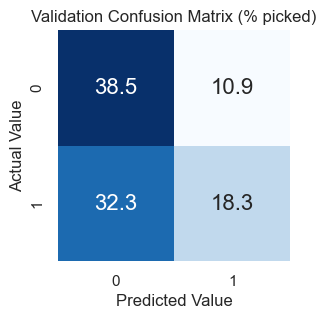

In [14]:
print_results()

In [13]:
## Third Model ~67% accuracy on validation after 740 epochs weighs about 64/35 0/1
# model.save_weights('model3.h5')
# model.save_weights('model3b.h5')
model = Sequential([
    Conv2D(filters=15, kernel_size=3, input_shape=(scale[0]*2, scale[1], 1)),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax'),
])
## Uncomment and run the last two lines if you want to load in the model weights
## if you load the model weights you DO NOT need to compile, you can just run the test block
# model.load_weights('model3.h5')
# epochs_on_model = 740

## Model 3b (more training) ~61% accuracy but with better results on ground positives
## This is the model that was further trained with varying weights to try to produce better results on ground positives
## To recreate the training it is:
## To run this train the code with the block labeled "## Train Model 3b"
## 740 epochs, class_weight=default_class_weights
## 100 epochs, class_weight={0: 1, 1: 1.5}
## 100 epochs, class_weight={0: 1, 1: 1}
## 160 epochs, class_weight={0: 1, 1: 1.5}
## 100 epochs, class_weight={0: 1, 1: 1}
## 100 epochs, class_weight={0: 1, 1: 1.2}
## 700 epochs, class_weight={0: 1, 1: 1.3}
##
## or you can just load the finished model by uncommenting the last two lines
# model.load_weights('model3b.h5')
# epochs_on_model = 2000

In [14]:
## Compile Model 3/3b
epochs_on_model = 0
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy', 'binary_crossentropy'],
)

In [ ]:
## Train Model 3
epochs_this = 700
epochs_on_model += epochs_this
callbacks_list = [PlotLearning()]

model.fit(
    gen.flow(X_train, to_categorical(y_train)),
    epochs=epochs_this,
    validation_data=(X_test, to_categorical(y_test)),
    class_weight=default_class_weights,
    callbacks=callbacks_list,
)

In [ ]:
print_results()

In [ ]:
## Train Model 3b
## NOTE: this is intended to be run AFTER the block above for training model 3 is run
## as it continues the training
runs = [[100, {0: 1, 1: 1.5}], 
        [100, {0: 1, 1: 1}],
        [160, {0: 1, 1: 1.5}],
        [100, {0: 1, 1: 1}],
        [100, {0: 1, 1: 1.2}],
        [700, {0: 1, 1: 1.3}],
       ]
for i in range(len(runs)):
    epochs_this = runs[i][0]
    epochs_on_model += epochs_this
    callbacks_list = [PlotLearning()]

    model.fit(
        gen.flow(X_train, to_categorical(y_train)),
        epochs=epochs_this,
        validation_data=(X_test, to_categorical(y_test)),
        class_weight=runs[i][1],
        callbacks=callbacks_list,
    )

Epochs so far: 2000

65/65 [==============================] - 0s 5ms/step
Train Accuracy = 0.7572815533980582
9/9 [==============================] - 0s 4ms/step
Test Accuracy = 0.627906976744186
9/9 [==============================] - 0s 3ms/step
Validation Accuracy = 0.6303501945525292

Predicted Percentages: 
[[ 0.         40.46692607]
 [ 1.         59.53307393]]

Ground Percentages: 
[[ 0.         49.41634241]
 [ 1.         50.58365759]]



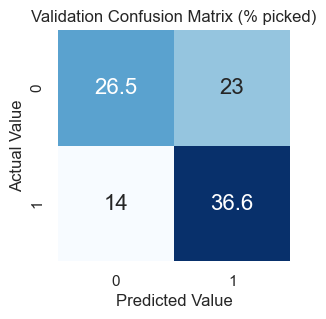

In [19]:
print_results()

In [13]:
## Set up Final Model
## Unfortunately due to a computer crash I don't have the model weights saved so you'll have to run it to get it
model = Sequential([
    Conv2D(filters=20, kernel_size=3, input_shape=(scale[0]*2, scale[1], 1)),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(1500, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax'),
])
epochs_on_model = 0

In [14]:
## Compile Final Model
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(
  opt,
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

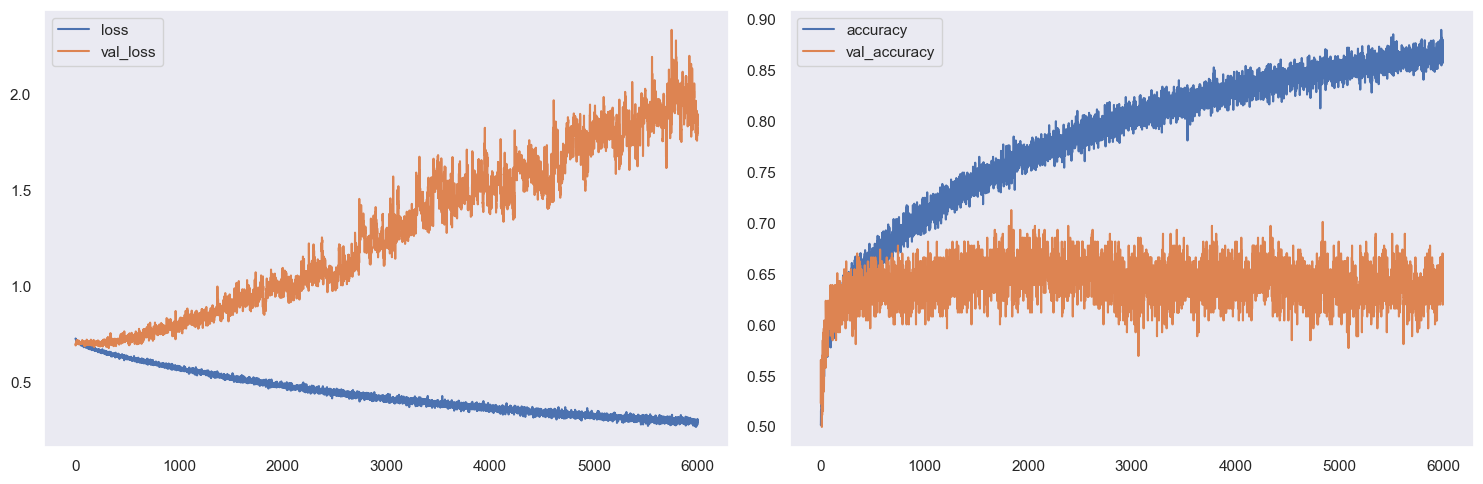

65/65 [==============================] - 5s 70ms/step - loss: 0.2845 - accuracy: 0.8806 - val_loss: 1.8412 - val_accuracy: 0.6357


In [16]:
## Train Model
epochs_this = 6000
epochs_on_model += epochs_this
callbacks_list = [PlotLearning()]
class_weights_biased = {0: 1, 1: 1.1}

model.fit(
    gen.flow(X_train, to_categorical(y_train)),
    epochs=epochs_this,
    validation_data=(X_test, to_categorical(y_test)),
    class_weight=class_weights_biased,
    callbacks=callbacks_list,
)

In [ ]:
print_results()